# piston example with explicit Euler scheme

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import numpy as np

import sys
sys.path.insert(0, './code')

import ideal_gas

### physical parameters

In [2]:
# length of cylinder
l = 0.1

# radius of cylinder
r = 0.05 

# thickness of wall
w = 0.006

# derived geometrical data
r2 = 2 * r          # diameter of cylinder
w2 = w / 2          # halved thickness of wall
l2 = l - w2
A = r**2 * np.pi    # cross-sectional area

In [3]:
def get_v_1(q):
    """first volume"""
    return A * (q - w2)
    
def get_v_2(q):
    """second volume"""
    return A * (l2 - q)

In [4]:
# density of aluminium
m_Al = 2700.0
m_Cu = 8960.0

# mass of piston
m = m_Cu * A * w

# thermal conductivity of aluminium
κ_Al = 237.0
κ_Cu = 401.0

# thermal conduction coefficient
α = κ_Cu * A / w

m_inv = 1 / m

### initial conditions

determine $n_1$, $n_2$, $s_1$, $s_2$

In [5]:
# wanted conditions
v_1 = v_2 = get_v_1(l/2)
θ_1 = 273.15 + 25.0
π_1 = 1.5 * 1e5
θ_2 = 273.15 + 20.0
π_2 = 1.0 * 1e5

In [6]:
from scipy.optimize import fsolve

In [7]:
n_1 = fsolve(lambda n : ideal_gas.S_π(ideal_gas.U2(θ_1, n), v_1, n) - π_1, x0=2e22)[0]
s_1 = ideal_gas.S(ideal_gas.U2(θ_1, n_1), v_1, n_1)

In [8]:
# check temperature
ideal_gas.U_θ(s_1, v_1, n_1) - 273.15

25.00000000000159

In [9]:
# check pressure
ideal_gas.U_π(s_1, v_1, n_1) * 1e-5

1.5000000000000082

In [10]:
n_2 = fsolve(lambda n : ideal_gas.S_π(ideal_gas.U2(θ_2, n), v_2, n) - π_2, x0=2e22)[0]
s_2 = ideal_gas.S(ideal_gas.U2(θ_2, n_2), v_2, n_2)

In [11]:
# check temperature
ideal_gas.U_θ(s_2, v_2, n_2) - 273.15

20.00000000000415

In [12]:
# check pressure
ideal_gas.U_π(s_2, v_2, n_2) * 1e-5

1.0000000000000142

In [13]:
x_0 = l/2, 0, s_1, s_2

### simulation

In [14]:
def set_state(data, i, x):
    q, p, s_1, s_2 = x

    data[i, 0] = q
    
    data[i, 1] = p
    data[i, 2] = v = m_inv * p
    
    data[i, 3] = v_1 = get_v_1(q)
    data[i, 4] = π_1 = ideal_gas.U_π(s_1, v_1, n_1)
    
    data[i, 5] = s_1
    data[i, 6] = θ_1 = ideal_gas.U_θ(s_1, v_1, n_1)
    
    data[i, 7] = v_2 = get_v_2(q)
    data[i, 8] = π_2 = ideal_gas.U_π(s_2, v_2, n_2)

    data[i, 9] = s_2
    data[i, 10] = θ_2 = ideal_gas.U_θ(s_2, v_2, n_2)
    
    data[i, 11] = E_kin = 0.5 * m_inv * p**2
    data[i, 12] = u_1 = ideal_gas.U(s_1, v_1, n_1)
    data[i, 13] = u_2 = ideal_gas.U(s_2, v_2, n_2)
    data[i, 14] = E = E_kin + u_1 + u_2
    data[i, 15] = S = s_1 + s_2

    
def get_state(data, i):
    return data[i, (0, 1, 5, 9)]

In [15]:
def rhs(x):
    """right hand side of the explicit system
    of differential equations
    """
    q, p, s_1, s_2 = x
    
    v_1 = get_v_1(q)
    v_2 = get_v_2(q)
    
    π_1 = ideal_gas.U_π(s_1, v_1, n_1)
    π_2 = ideal_gas.U_π(s_2, v_2, n_2)
    
    θ_1 = ideal_gas.U_θ(s_1, v_1, n_1)
    θ_2 = ideal_gas.U_θ(s_2, v_2, n_2)
    
    return np.array((m_inv*p, A*(π_1-π_2), α*(θ_2-θ_1)/θ_1, α*(θ_1-θ_2)/θ_2))

In [17]:
t_f = 1.0
dt = 1e-4

steps = int(t_f // dt)
print(f'steps={steps}')

t = np.linspace(0, t_f, num=steps)
dt = t[1] - t[0]

data = np.empty((steps, 16), dtype=float)
set_state(data, 0, x_0)

x_old = get_state(data, 0)
for i in range(1, steps):
    x_new = x_old + dt * rhs(x_old)
    set_state(data, i, x_new)
    x_old = x_new

θ_min = np.min(data[:, (6,10)])
θ_max = np.max(data[:, (6,10)])

steps=9999


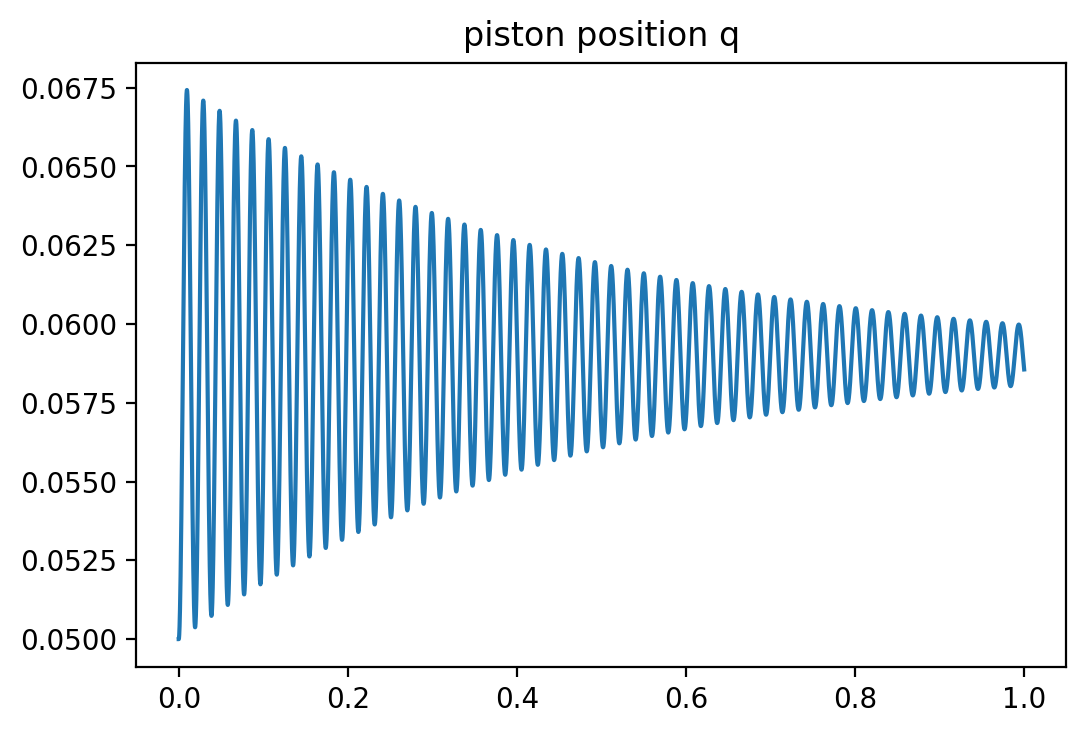

In [19]:
# plot transient
fig, ax = plt.subplots(dpi=200)
ax.set_title("piston position q")
ax.plot(t, data[:, 0]);

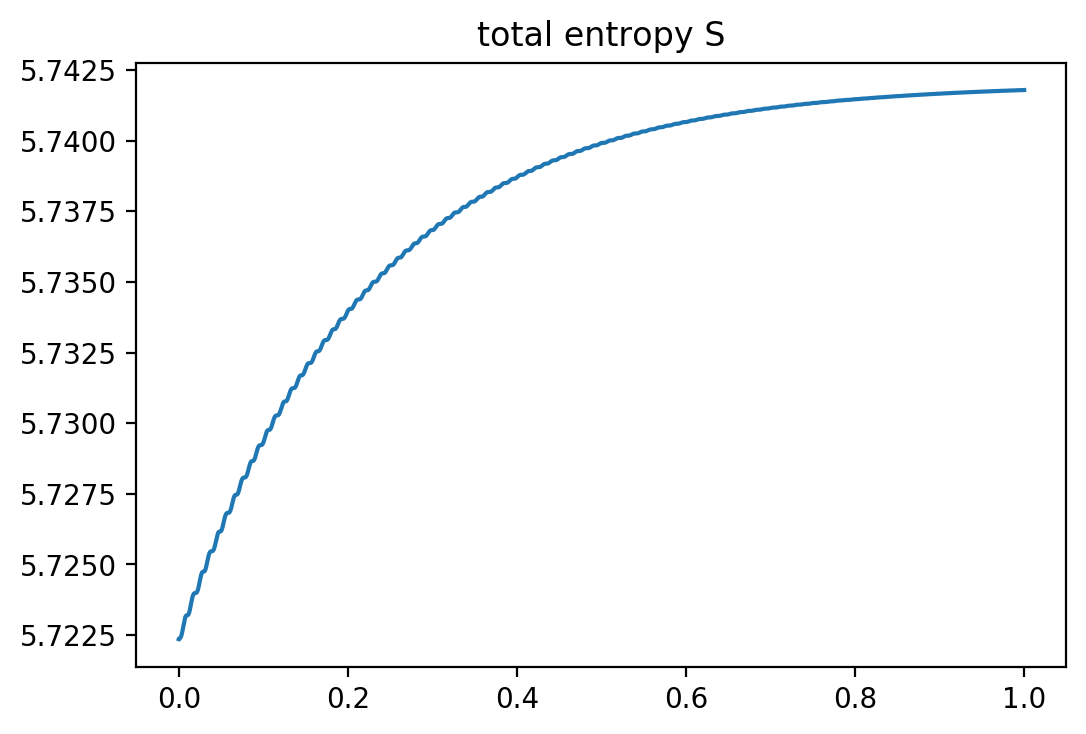

In [20]:
fig, ax = plt.subplots(dpi=200)
ax.set_title("total entropy S")
ax.plot(t, data[:, 15]);

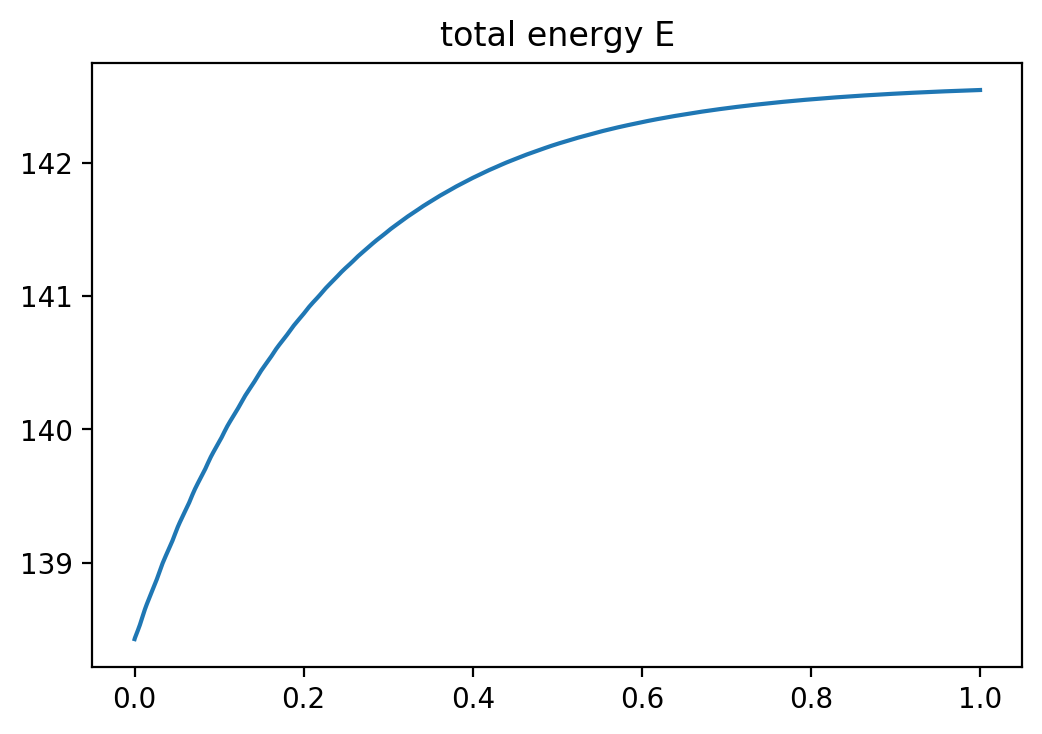

In [22]:
fig, ax = plt.subplots(dpi=200)
ax.set_title("total energy E")
ax.plot(t, data[:, 14]);

the total energy is not conserved well